## How to train a basic deep net as a controller
This notebook outlines how to build a point-mass object to serve as a plant, and then plug it to a deep net.

We then proceed to training the net for a delayed reaching task, and plot example simulations once the training is done.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from tensorflow.keras.layers import Input

# find root directory and add to path
root_index = os.getcwd().rfind('MotorNet') + len('MotorNet') + 1
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

from MotorNet.plants import PlantWrapper
from MotorNet.plants.skeletons import PointMass
from MotorNet.plants.muscles import ReluMuscle
from MotorNet.utils.plotor import plot_pos_over_time
from MotorNet.nets.losses import empty_loss, position_loss, activation_squared_loss
from MotorNet.nets.layers import GRUController
from MotorNet.nets.callbacks import BatchLogger
from MotorNet.tasks import TaskDelayedReach
from MotorNet.nets.models import MotorNetModel

%load_ext autoreload
%autoreload 2

# tf.debugging.enable_check_numerics()
print('tensorflow version: ' + tf.__version__)
print('numpy version: ' + np.__version__)



tensorflow version: 2.6.0
numpy version: 1.21.2


In [3]:
plant = PlantWrapper(skeleton=PointMass(space_dim=2), muscle_type=ReluMuscle(), proprioceptive_delay=0.04, visual_delay=0.13)

plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[5, 5], [0, 0]], name='ur', max_isometric_force=500)
plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-5, 5], [0, 0]], name='ul', max_isometric_force=500)
plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[5, -5], [0, 0]], name='dr', max_isometric_force=500)
plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-5, -5], [0, 0]], name='dl', max_isometric_force=500)


In [6]:

cell = GRUController(plant=plant, n_units=50, kernel_regularizer=10**-6, name='cell')
task = TaskDelayedReach(cell, delay_range=[0.3, 0.6])


# declare inputs
inputs = {key: Input((None, val,), name=key) for key, val in task.get_input_dim().items()}
state0 = [Input((plant.output_dim, ), name='joint0'),
          Input((plant.output_dim, ), name='cartesian0'),
          Input((plant.muscle_state_dim, plant.n_muscles, ), name='muscle0'),
          Input((plant.geometry_state_dim, plant.n_muscles, ), name='geometry0'),
          Input((plant.n_muscles * 2, plant.proprioceptive_delay, ), name='proprio_feedback0'),
          Input((plant.space_dim, plant.visual_delay, ), name='visual_feedback0')]
state0.extend([Input((n, ), name='gru' + str(k) + '_hidden0') for k, n in enumerate(cell.n_units)])

# wrap cell in an RNN layer
rnn = tf.keras.layers.RNN(cell=cell, return_sequences=True, name='RNN')
states_out = rnn(inputs, initial_state=state0)
control_rnn = MotorNetModel(inputs=[inputs, state0], outputs=states_out, name='controller', task=task)

# and compile
control_rnn.compile(optimizer=tf.optimizers.Adam(clipnorm=1.), loss=losses, loss_weights=loss_weights)
batchlog_callback = BatchLogger()
control_rnn.summary()


Model: "controller"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
joint0 (InputLayer)             [(None, 4)]          0                                            
__________________________________________________________________________________________________
cartesian0 (InputLayer)         [(None, 4)]          0                                            
__________________________________________________________________________________________________
muscle0 (InputLayer)            [(None, 4, 4)]       0                                            
_________________________________________________________________________________________

In [7]:
dataset_size = 2000 * 32
n_t = int(1 / plant.dt)

with tf.device('/cpu:0'):
    [inputs, targets, init_states] = task.generate(batch_size=dataset_size, n_timesteps=n_t)
    control_rnn.fit([inputs, init_states], targets, epochs=1, batch_size=32, verbose=1, callbacks=[batchlog_callback], shuffle=False)


2000/2000 [==============================] - 208s 101ms/step - loss: 0.0953 - RNN_loss: 0.0952 - RNN_1_loss: 0.0000e+00 - RNN_2_loss: 0.0000e+00 - RNN_3_loss: 0.0000e+00 - RNN_4_loss: 5.9586e-04 - RNN_5_loss: 0.0000e+00 - RNN_6_loss: 0.0000e+00 - ETA: 3:26 - loss: 0.3527 - RNN_loss: 0.

last loss value = 0.09530101716518402


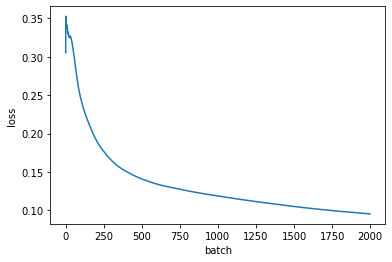

In [8]:
if 'loss' in batchlog_callback.history:
    last_loss = batchlog_callback.history['loss'][-1]
    print('last loss value = ' + str(last_loss))
    plt.plot(batchlog_callback.history['loss'])
    plt.xlabel('batch')
    plt.ylabel('loss')
    # plt.semilogy()
    plt.show()


In [9]:
def grad(model, model_inputs, y_true, loss):
    with tf.GradientTape() as tape:
        model_pred = model(model_inputs, training=False)
        y_pred = model_pred['cartesian position']
        loss_value = loss(y_true=y_true, y_pred=y_pred)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


[inputs_sample, targets_sample, init_states_sample] = task.generate(batch_size=1, n_timesteps=n_t)
loss_val, gradients = grad(control_rnn, [inputs_sample, init_states_sample], targets_sample, position_loss())
# gradients



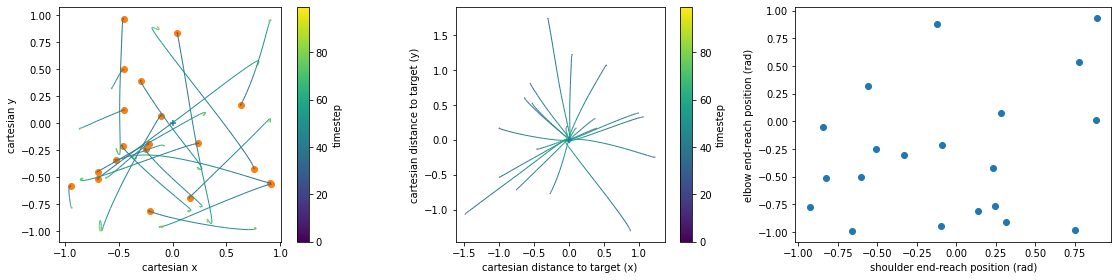

In [10]:

[inputs_sample, targets_sample, init_states_sample] = task.generate(batch_size=20, n_timesteps=n_t)
results = control_rnn([inputs_sample, init_states_sample], training=False)

j_results = results['joint position']
c_results = results['cartesian position']
m_results = results['muscle state']

plt.figure(figsize=(16, 4)).set_tight_layout(True)
plt.subplot(131)
plot_pos_over_time(cart_results=c_results)
plt.scatter(targets_sample[:, 0, 0], targets_sample[:, 0, 1])

plt.subplot(132)
plot_pos_over_time(cart_results=c_results - np.expand_dims(targets_sample[:,-1,:], axis=1))
plt.xlabel('cartesian distance to target (x)')
plt.ylabel('cartesian distance to target (y)')

plt.subplot(133)
plt.scatter(j_results[:,-1,0].numpy().T, j_results[:,-1,1].numpy().T)
plt.xlabel('shoulder end-reach position (rad)')
plt.ylabel('elbow end-reach position (rad)')
plt.show()


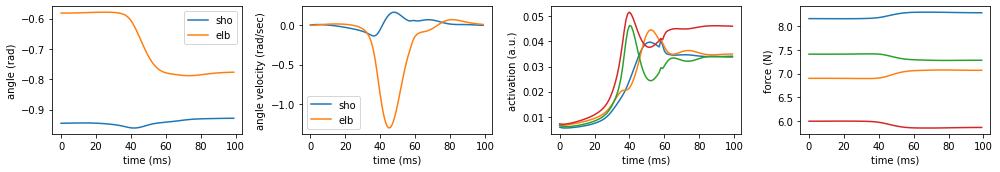

In [11]:
trial = 10
plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

plt.subplot(141)
plt.plot(j_results[trial, :, 0].numpy().squeeze(), label='sho')
plt.plot(j_results[trial, :, 1].numpy().squeeze(), label='elb')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('angle (rad)')

plt.subplot(142)
plt.plot(j_results[trial, :, 2].numpy().squeeze(), label='sho')
plt.plot(j_results[trial, :, 3].numpy().squeeze(), label='elb')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('angle velocity (rad/sec)')

plt.subplot(143)
plt.plot(m_results[trial, :, 0, :].numpy().squeeze())
plt.xlabel('time (ms)')
plt.ylabel('activation (a.u.)')

plt.subplot(144)
plt.plot(m_results[trial, :, 1, :].numpy().squeeze())
plt.xlabel('time (ms)')
plt.ylabel('force (N)')

plt.show()



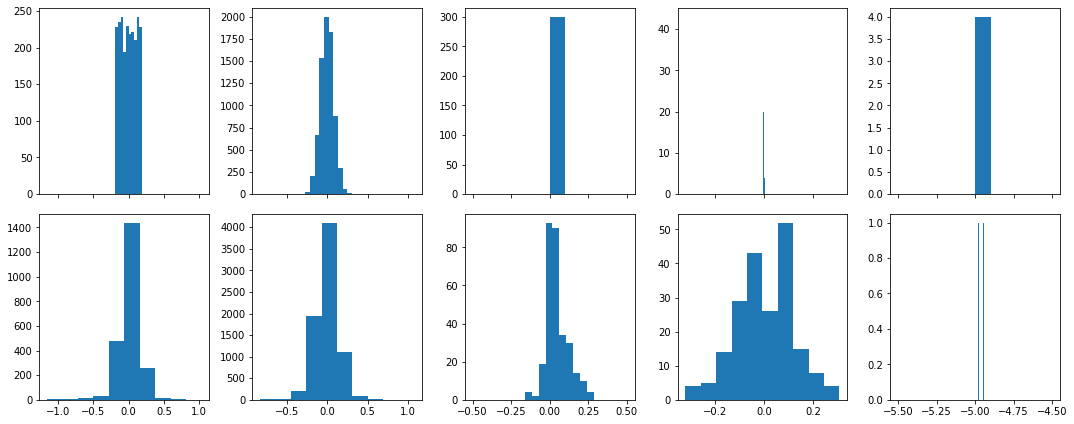

In [12]:
if len(batchlog_callback.weights_log) > 0:
    w0 = batchlog_callback.weights_log[0]
    w1 = batchlog_callback.weights_log[-1]

    fig, axs = plt.subplots(nrows=2, ncols=len(w0), sharex='col')
    fig.set_tight_layout(tight=True)
    fig.set_size_inches((15, 6))

    for n in range(len(w0)):
        weights_ini = w0[n].numpy()
        weights_fin = w1[n].numpy()

        if len(weights_ini.shape) < 10:
            axs[0,n].hist(weights_ini.flatten())
            axs[1,n].hist(weights_fin.flatten())
        else:
            axs[0,n].imshow(weights_ini, interpolation='none')
            axs[1,n].imshow(weights_fin, interpolation='none')

    plt.show()


















